# Chapter 8. 이미지를 분류합니다. - 합성곱 신경망
## 08-1 합성곱 연산에 대해 알아봅니다.
### 합성곱 구현하기
#### 1. 넘파이 배열 정의하고 배열 하나 선택해 뒤집기


In [1]:
import numpy as np
w = np.array([2, 1, 5, 3])
x = np.array([2, 8, 3, 7, 1, 2, 0, 4, 5])
# 배열 뒤집어주기 
w_r = np.flip(w)	# 넘파이의 flip() 함수 사용	
print(w_r) 
w_r = w[::-1]		# 슬라이스 연산자 사용
print(w_r) 

[3 5 1 2]
[3 5 1 2]


#### 2. 넘파이의 점 곱으로 합성곱 수행하기
x배열을 한칸씩 이동하면서 합성곱 수행하기

In [2]:
for i in range(6):
	print(np.dot(x[i:i+4],w_r))

63
48
49
28
21
20


#### 3. 싸이파이로 합성곱 수행하기
싸이파이는 합성곱을 위한 함수 convolve()를 제공한다.

In [3]:
from scipy.signal import convolve
convolve(x, w, mode='valid')

array([63, 48, 49, 28, 21, 20])

### 합성곱 신경망은 진짜 합성곱을 사용하지 않습니다.

In [4]:
from scipy.signal import correlate
correlate(x, w, mode='valid')

array([48, 57, 24, 25, 16, 39])

### 패딩과 스트라이드를 이해합니다.

#### 밸리드 패딩은 원본 배열의 원소가 합성곱 연산에 참여하는 정도가 서로 다릅니다

In [5]:
correlate(x, w, mode='valid')

array([48, 57, 24, 25, 16, 39])

#### 풀 패딩은 원본 배열 요소의 연산 참여도를 동일하게 만듭니다

In [6]:
correlate(x, w, mode='full')

array([ 6, 34, 51, 48, 57, 24, 25, 16, 39, 29, 13, 10])

#### 세임 패딩은 출력 배열의 길이를 원본 배열의 길이와 동일하게 만듭니다
출력 배열의 길이가 원본 배열의 길이와 같아지도록 원본 배열에 제로 패딩을 추가한다. 

In [7]:
correlate(x, w, mode='same')

array([34, 51, 48, 57, 24, 25, 16, 39, 29])

### 2차원 배열에서 합성곱을 수행합니다.
싸이파이의 correlate2d() 함수를 사용하여 2차원 배열의 합성곱을 계산할 수 있다.

In [8]:
from scipy.signal import correlate2d
x = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
w = np.array([[2, 0], [0, 0]])
correlate2d(x, w, mode='valid')

array([[ 2,  4],
       [ 8, 10]])

In [9]:
correlate2d(x, w, mode='same')

array([[ 2,  4,  6],
       [ 8, 10, 12],
       [14, 16, 18]])

### 탠서플로로 합성곱을 수행합니다.
#### 2차원 배열을 4차원 배열로 바꿔 합성곱을 수행합니다
텐서플로는 4차원 배열의 입력을 기대하기때문에 앞에서의 입력 x와 가중치 w를 넘파이의 reshape() 메소드로 2차원 배열에서 4차원 배열로 바꾼다.  
또한 텐서플로는 실수형의 입력을 기대하기 때문에 넘파이의 astype() 메소드로 입력의 자료형을 실수로 바꾼다.  
배치와 컬러 채널은 1

In [10]:
import tensorflow as tf
x_4d = x.astype(np.float).reshape(1, 3, 3, 1)   # 4차원 배열로 바꾸고 실수형으로 바꾸기
w_4d = w.reshape(2, 2, 1, 1)                    # 4차원 배열로 바꾸기

스트라이드는 1, 패딩은 세임 패딩

In [11]:
c_out = tf.nn.conv2d(x_4d, w_4d, strides=1, padding='SAME')

conv2d 함수는 텐서플로의 Tensor 객체를 리턴한다.  
(Tensor는 텐서플로에서 다차원 배열을 부르는 것)  
Tensor 객체의 numpy() 메소드를 이용해서 넘파일 배열로 변환해주는데 편의상 배치 차원과 컬러 차원을 제거하고 (3, 3) 크기로 변환하자.

In [12]:
c_out.numpy().reshape(3, 3)

array([[ 2.,  4.,  6.],
       [ 8., 10., 12.],
       [14., 16., 18.]])

2차원 배열로 실습한 correlate2d()의 결과와 같지만 4차원 배열임을 잊지 말자.  
--> MD문서로

## 08-2 풀링 연산에 대해 알아봅니다.
### 최대 풀링과 평균 풀링을 수행합니다.
텐서플로의 max_pool2d() 함수를 사용하면 최대 풀링을 수행할 수 있다.  
먼저 4×4 크기의 배열을 만든 다음 1×4×4×1 크기의 배열로 변형한다. 

In [13]:
x = np.array([[1, 2, 3, 4], 
              [5, 6, 7, 8], 
              [9, 10, 11, 12], 
              [13, 14, 15, 16]])
x = x.reshape(1, 4, 4, 1)

max_pool2d()에서 풀링의 크기를 ksize 매개변수에, 스트라이드 크기를 strides 매개변수에 지정한다.

In [14]:
p_out = tf.nn.max_pool2d(x, ksize=2, strides=2, padding='VALID')
p_out.numpy().reshape(2, 2)   # numpy 배열로 변환한 후 2차원 배열로 변형

array([[ 6.,  8.],
       [14., 16.]], dtype=float32)

풀링층에는 학습되는 가중치가 없다.   
또한 풀링은 배치차원이나 채널 차원으로 적용되지 않는다.  
즉, 풀링층을 통과하기 전후로 배치 크기와 채널 크기는 동일하다.  
*--> MD 문서로*

## 08-4 합성곱 신경망을 만들고 훈련합니다.
### 합성곱 신경망의 역방향 계산 구현하기
#### 자동 미분의 사용 방법을 알아봅니다
딥러닝 패키지들은 사용자가 작성한 연산을 계산 그래프 (computation graph)로 만들어 자동 미분 기능을 구현한다.  
자동 미분 기능을 사용하면 임의의 파이썬 코드나 함수에 대한 미분값을 계산할 수 있다.
  
자동 미분 기능을 사용하려면 with 블럭으로 tf.GradientTape() 객체가 감시할 코드를 감싸야 한다.  
tape 객체는 with 블럭 안에서 일어나는 모든 연산을 기록하고 텐서플로 객체인 tf.Variable 객체를 자동으로 추적한다. 
그래디언트를 계산하려면 미분 대상 객체와 변수를 tape객체의 gradient() 메서드에 전달하면 된다. 


In [15]:
x = tf.Variable(np.array([1.0, 2.0, 3.0]))
with tf.GradientTape() as tape:
  y = x ** 3 + 2 * x + 5

# 그래디언트를 계산
print(tape.gradient(y, x))

tf.Tensor([ 5. 14. 29.], shape=(3,), dtype=float64)


--> MD 문서로

ConvolutionNerwork 클래스의 전체 코드

In [24]:
import tensorflow as tf

class ConvolutionNetwork:
    
    def __init__(self, n_kernels=10, units=10, batch_size=32, learning_rate=0.1):
        self.n_kernels = n_kernels  # 합성곱의 커널 개수
        self.kernel_size = 3        # 커널 크기
        self.optimizer = None       # 옵티마이저
        self.conv_w = None          # 합성곱 층의 가중치
        self.conv_b = None          # 합성곱 층의 절편
        self.units = units          # 은닉층의 뉴런 개수
        self.batch_size = batch_size  # 배치 크기
        self.w1 = None              # 은닉층의 가중치
        self.b1 = None              # 은닉층의 절편
        self.w2 = None              # 출력층의 가중치
        self.b2 = None              # 출력층의 절편
        self.a1 = None              # 은닉층의 활성화 출력
        self.losses = []            # 훈련 손실
        self.val_losses = []        # 검증 손실
        self.lr = learning_rate     # 학습률

    def forpass(self, x):
        # 3x3 합성곱 연산을 수행합니다.
        c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding='SAME') + self.conv_b
        # 렐루 활성화 함수를 적용합니다.
        r_out = tf.nn.relu(c_out)
        # 2x2 최대 풀링을 적용합니다.
        p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID')
        # 첫 번째 배치 차원을 제외하고 출력을 일렬로 펼칩니다.
        f_out = tf.reshape(p_out, [x.shape[0], -1])
        z1 = tf.matmul(f_out, self.w1) + self.b1     # 첫 번째 층의 선형 식을 계산합니다
        a1 = tf.nn.relu(z1)                          # 활성화 함수를 적용합니다
        z2 = tf.matmul(a1, self.w2) + self.b2        # 두 번째 층의 선형 식을 계산합니다.
        return z2
    
    def init_weights(self, input_shape, n_classes):
        g = tf.initializers.glorot_uniform()
        self.conv_w = tf.Variable(g((3, 3, 1, self.n_kernels)))
        self.conv_b = tf.Variable(np.zeros(self.n_kernels), dtype=float)
        n_features = 14 * 14 * self.n_kernels
        self.w1 = tf.Variable(g((n_features, self.units)))          # (특성 개수, 은닉층의 크기)
        self.b1 = tf.Variable(np.zeros(self.units), dtype=float)    # 은닉층의 크기
        self.w2 = tf.Variable(g((self.units, n_classes)))           # (은닉층의 크기, 클래스 개수)
        self.b2 = tf.Variable(np.zeros(n_classes), dtype=float)     # 클래스 개수
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.init_weights(x.shape, y.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)
        # epochs만큼 반복합니다.
        for i in range(epochs):
            print('에포크', i, end=' ')
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            batch_losses = []
            for x_batch, y_batch in self.gen_batch(x, y):
                print('.', end='')
                self.training(x_batch, y_batch)
                # 배치 손실을 기록합니다.
                batch_losses.append(self.get_loss(x_batch, y_batch))
            print()
            # 배치 손실 평균내어 훈련 손실 값으로 저장합니다.
            self.losses.append(np.mean(batch_losses))
            # 검증 세트에 대한 손실을 계산합니다.
            self.val_losses.append(self.get_loss(x_val, y_val))

    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y):
        bins = len(x) // self.batch_size                   # 미니배치 횟수
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.
            
    def training(self, x, y):
        m = len(x)                    # 샘플 개수를 저장합니다.
        with tf.GradientTape() as tape:
            z = self.forpass(x)       # 정방향 계산을 수행합니다.
            # 손실을 계산합니다.
            loss = tf.nn.softmax_cross_entropy_with_logits(y, z)
            loss = tf.reduce_mean(loss)

        weights_list = [self.conv_w, self.conv_b,
                        self.w1, self.b1, self.w2, self.b2]
        # 가중치에 대한 그래디언트를 계산합니다.
        grads = tape.gradient(loss, weights_list)
        # 가중치를 업데이트합니다.
        self.optimizer.apply_gradients(zip(grads, weights_list))
   
    def predict(self, x):
        z = self.forpass(x)                 # 정방향 계산을 수행합니다.
        return np.argmax(z.numpy(), axis=1) # 가장 큰 값의 인덱스를 반환합니다.
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == np.argmax(y, axis=1))

    def get_loss(self, x, y):
        z = self.forpass(x)                 # 정방향 계산을 수행합니다.
        # 손실을 계산하여 저장합니다.
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, z))
        return loss.numpy()

### 합성곱 신경망 훈련하기
#### 1. 데이터 세트 불러오기

In [26]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

#### 2. 훈련 데이터 세트를 훈련 세트와 검증 세트로 나누기

In [27]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, 
                                                  test_size=0.2, random_state=42)

#### 3. 타깃을 원-핫 인코딩으로 변환하기
합성곱 신경망의 타깃으로 사용하려면 y_train, y_val 배열의 요소들을 원-핫 인코딩으로 변경해야 한다.

In [28]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

#### 4. 입력 데이터 준비하기
합성곱 신경망은 입력데이터의 높이와 너비 차원을 그대로 유지한 채 신경망에 주입할 수 있지만 마지막에 컬러 채널을 추가해야 한다.  
흑백 이미지에는 컬러 채널이 없지만 명암을 나타내는 1차원 채널이 있다고 가정한다.

In [29]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

In [30]:
x_train.shape

(48000, 28, 28, 1)

#### 5. 입력 데이터 표준화 전처리하기
입력 데이터를 255로 나누어 0~1사이의 값으로 조정한다. 

In [31]:
x_train = x_train / 255
x_val = x_val / 255

#### 6. 모델 훈련하기
합성곱 커널 10개 완전 연결층의 뉴런 100개, 배치 크기 128개, 학습률 0.01로 지정하여 모델을 훈련한다. 

In [32]:
cn = ConvolutionNetwork(n_kernels=10, units=100, batch_size=128, learning_rate=0.01)
cn.fit(x_train, y_train_encoded, 
       x_val=x_val, y_val=y_val_encoded, epochs=20)

에포크 0 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 1 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 2 ......................................................................................................................................................................................................................................

#### 7. 훈련, 검증 손실 그래프 그리고 검증 세트의 정확도 확인하기
검증 세트에 대한 정확도를 측정하면 88%에 가깝다.

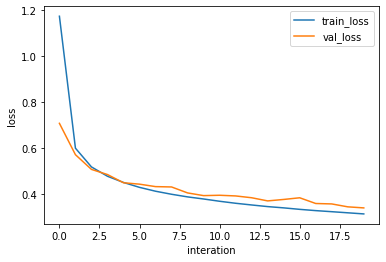

In [33]:
import matplotlib.pyplot as plt

plt.plot(cn.losses)
plt.plot(cn.val_losses)
plt.ylabel('loss')
plt.xlabel('interation')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [34]:
cn.score(x_val, y_val_encoded)

0.88325

## 08-5 케라스로 합성곱 신경망을 만듭니다.
### 케라스로 합성곱 신경망 만들기
케라스의 함성곱층은 Con2D클래스이다.  
최대 풀링은 MaxPooling2D클래스를 사용하고, 특성 맵을 일렬로 펼칠 때는 Flatten 클래스를 사용한다.
 


#### 1. 필요한 클래스들을 임포트하기

In [35]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

#### 2. 합성곱층 쌓기
Conv2D 클래스의 첫번째 매개변수는 합성곱 커널의 개수, 두번째 매개변수는 합성곱 커널의 크기로 높이와 너비를 튜플로 전달한다.  
activation 매개변수에는 렐루 활성화 함수를 지정하고, 패딩은 세임 패딩을 사용하는데 이번에는 대소문자를 구분하지 않는다.  
Sequential 클래스에 층을 처음 추가할때는 배치 차원을 제외한 입력의 크기를 지정한다.  
여기서는 패션 MNIST 이미지의 높이와 너비, 컬러 채널이 입력의 크기가 된다. 

In [50]:
conv1 = tf.keras.Sequential()
conv1.add(Conv2D(10, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))

#### 3. 풀링층 쌓기
MaxPooling2D 클래스의 첫번째 매개변수: 풀링의 높이와 너비를 나타내느 튜플  
스트라이드는 strides 매개변수에 지정하고 기본값은 풀링의 크기이다.  
패딩은 padding 매개변수에 지정하고 기본값은 'vaild' 이다.  
여기서는 스트라이드와 패딩의 기본값을 사용한다. 

In [51]:
conv1.add(MaxPooling2D((2, 2)))

#### 4. 완전 연결층에 주입할 수 있도록 특성 맵 펼치기
배치차원을 제외하고 일렬로 펼치는 작업은 Flatten 클래스로 할 수 있다.  

In [52]:
conv1.add(Flatten())

#### 5. 완전 연결층 쌓기
첫번째 완전 연결층에는 100개의 뉴런을 사용하고 렐루 활성화 함수를 적용한다.  
마지막 출력층에는 10개의 클래스에 대응하는 10개의 뉴런을 사용하고 소프트맥스 활성화 함수를 적용한다. 

In [53]:
conv1.add(Dense(100, activation='relu'))
conv1.add(Dense(10, activation='softmax'))

#### 6. 모델 구조 살펴보기
모델의 summary() 메소드를 사용하면 conv1 모델의 구조를 조사할 수 있다.  

In [54]:
conv1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1960)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               196100    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
_________________________________________________________________


합성곱층의 출력 크기에서 배치차원이 None인데 그 이유는 훈련할 때 전달되는 샘플 개수에 따라 배치 입력의 개수가 달라지기 때문이다.  
가중치의 개수를 보면 완전 연결층에 비해 합성곱층의 가중치 개수가 아주 적은데 그렇게 때문에 합성곱층을 여러 개 추가해도 학습할 모델 파라미터의 개수가 크게 늘지 않기 때문에 계산 효율성이 좋다. 

### 합성곱 신경망 모델 훈련하기
#### 모델 훈련하기 
정확도를 관찰하기 위해서 metrics 매개변수에 'accuracy'를 리스트로 전달했다.

In [56]:
conv1.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

#### 2. 아담 옵티마이저 사용하기
이번에는 적응적 학습률 알고리즘 중 하나인 아담 옵티마이저를 사용한다.  
아담은 Adaptive Moment Estimation을 줄여만든 이름으로 손실 함수의 값이 최적값에 가까워질수록 학습률을 낮춰서 손실 함수의 값이 안정적으로 수렴될 수 있게 한다. 

In [57]:
history = conv1.fit(x_train, y_train_encoded, epochs=20, validation_data=(x_val, y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 20s 13ms/step - loss: 0.6084 - accuracy: 0.7848 - val_loss: 0.3370 - val_accuracy: 0.8779
Epoch 2/20
1500/1500 [==============================] - 19s 13ms/step - loss: 0.3082 - accuracy: 0.8903 - val_loss: 0.2913 - val_accuracy: 0.8957
Epoch 3/20
1500/1500 [==============================] - 19s 13ms/step - loss: 0.2742 - accuracy: 0.8998 - val_loss: 0.2702 - val_accuracy: 0.9063
Epoch 4/20
1500/1500 [==============================] - 19s 13ms/step - loss: 0.2360 - accuracy: 0.9115 - val_loss: 0.2667 - val_accuracy: 0.9057
Epoch 5/20
1500/1500 [==============================] - 19s 13ms/step - loss: 0.2036 - accuracy: 0.9243 - val_loss: 0.2493 - val_accuracy: 0.9119
Epoch 6/20
1500/1500 [==============================] - 19s 13ms/step - loss: 0.1824 - accuracy: 0.9327 - val_loss: 0.2401 - val_accuracy: 0.9158
Epoch 7/20
1500/1500 [==============================] - 19s 13ms/step - loss: 0.1641 - accuracy: 0.9404 - val_loss: 0.2445 -

#### 3. 손실 그래프와 정확도 그래프 확인하기
마지막 에포크에서 검증 세트의 대한 정확도가 92%로 크게 증가했지만 정확도와 손실을 보니 몇번의 에포크 만에 검증 손실이 크게 증가했다.  
이는 과대적합이 발생했음을 의미한다.

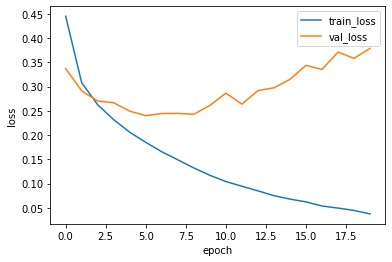

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

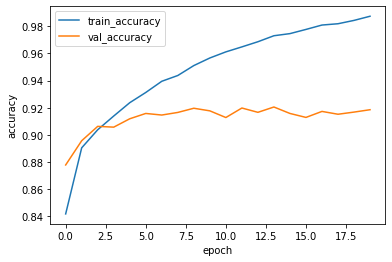

In [59]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

--> MD 문서로

### 드롭아웃 적용해 합성곱 신경망을 구현합니다.
텐서플로에서 드롭아웃을 적용하려면 Dropout 클래스를 추가하면 된다.  
Dropout 클래스의 매개변수에 드롭아웃될 비율을 실수로 지정한다.  
드롭아웃층에는 학습되는 가중치가 없고 단순히 일부 뉴런의 출력을 무작위로 0으로 만들고 나머지 뉴런의 출력을 드롭되지 않은 비율로 나누어 증가시킨다. 

In [61]:
from tensorflow.keras.layers import Dropout

conv2 = tf.keras.Sequential()
conv2.add(Conv2D(10, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
conv2.add(MaxPooling2D((2, 2)))
conv2.add(Flatten())
conv2.add(Dropout(0.5))
conv2.add(Dense(100, activation='relu'))
conv2.add(Dense(10, activation='softmax'))

#### 2. 드롭아웃층 확인하기
드롭아웃층은 훈련되는 가중치가 없고 텐서의 차원을 바꾸지 않는다. 

In [62]:
conv2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1960)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1960)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               196100    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
________________________________________________

#### 3. 훈련하기

In [66]:
conv2.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
history = conv2.fit(x_train, y_train_encoded, epochs=20, validation_data=(x_val, y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 21s 14ms/step - loss: 0.6778 - accuracy: 0.7583 - val_loss: 0.3298 - val_accuracy: 0.8849
Epoch 2/20
1500/1500 [==============================] - 21s 14ms/step - loss: 0.3704 - accuracy: 0.8645 - val_loss: 0.3074 - val_accuracy: 0.8888
Epoch 3/20
1500/1500 [==============================] - 20s 13ms/step - loss: 0.3292 - accuracy: 0.8797 - val_loss: 0.2737 - val_accuracy: 0.9007
Epoch 4/20
1500/1500 [==============================] - 20s 13ms/step - loss: 0.3011 - accuracy: 0.8905 - val_loss: 0.2647 - val_accuracy: 0.9031
Epoch 5/20
1500/1500 [==============================] - 20s 13ms/step - loss: 0.2894 - accuracy: 0.8909 - val_loss: 0.2517 - val_accuracy: 0.9088
Epoch 6/20
1500/1500 [==============================] - 20s 13ms/step - loss: 0.2723 - accuracy: 0.8978 - val_loss: 0.2480 - val_accuracy: 0.9101
Epoch 7/20
1500/1500 [==============================] - 20s 13ms/step - loss: 0.2550 - accuracy: 0.9039 - val_loss: 0.2404 -

#### 4. 손실 그래프와 정확도 그래프 그리기

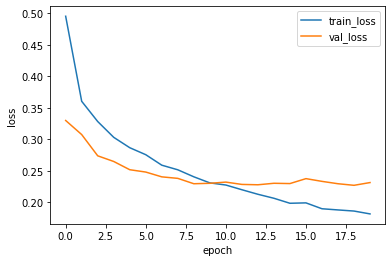

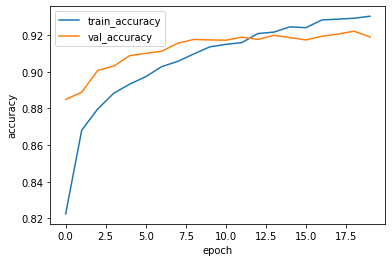

In [68]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

검증 손실이 증가되는 에포크가 확실히 늦춰졌고 훈련 손실과의 차이도 좁아졌다.  
정확도도 미세하게 증가했다.  
분류 문제에서 정확로를 직접 최적화할수는 없지만 크로스 엔트로피 손실함수를 대신 최적화한다.